## Bidirectional LSTM + Character-level-embedding + CRF

### Running on the small size data to prepare the training dataset

https://www.depends-on-the-definition.com/lstm-with-char-embeddings-for-ner/

Enhancing sequence tagging: Bidirectional LSTMs With Character Embeddings For Named Entity Recognition

In [1]:
import glob, os, csv, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# AUTO-LABELLED DATA SET = TRAIN SET + VALIDATION SET
filename = r"../1-2 OzROCK/Files/OzROCK dataset/BIG_set_byDictionary.txt"

#filename = r"C:\Users\20230326\wamex\data\OzROCK_Labeled_Geological_Dataset.txt"  # 480 files
#data = pd.read_csv(filename, header = None, delimiter=" ", na_values=['\n'], quoting=csv.QUOTE_NONE, encoding='latin1', skip_blank_lines=True)
#print(data.info())
#print(data.head(10))

#data = dataframes.where((pd.notnull(dataframes)), None)
#data = data.fillna('')
#data = data.replace(np.nan, '', regex=True)

words = []
tags = []
train_sentences = []

with open(filename, 'r') as file :
    currSentence = []
    lines = []
    for line in file:
        cols = line.split(" ") # should be lower-case already
        if line.strip() == '':
            # Reset sentence            
            train_sentences.append(currSentence)
            currSentence = []
        elif len(cols) > 2:
            print(line)
        else:
            currSentence.append([cols[0].strip(), cols[1].strip()])
            words.append(cols[0].strip())
            tags.append(cols[1].strip())
print('Num sentences = ', len(train_sentences)) # 18589; 160,343

train_words = list(set(words))
print('Num words in training set = ', len(train_words))

train_sent_lengths = [len(s) for s in train_sentences]

plt.hist(train_sent_lengths, density=1, bins=1000) # x value is bins
plt.axis([0, 140, 0, 0.1])  # xmin,xmax,ymin,ymax
plt.xlabel('Sentence Length')
plt.ylabel('Percentage of sentences')

plt.show()

Num sentences =  31813
Num words in training set =  24819


<Figure size 640x480 with 1 Axes>

Num lines =  53295
Num test_sentences =  2000
Num test_words =  4910
13


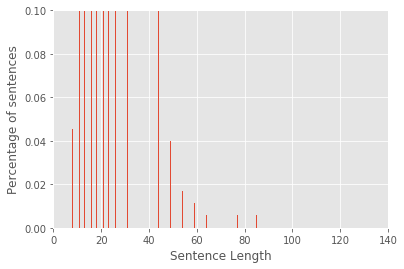

In [2]:
# TEST DATA - manually annotated
file_in = r"../1-2 OzROCK/Files/OzROCK dataset/EvaluationSet_annotated_by_doman_experts.txt" # TestSet_March02
filename_result = r"../1-2 OzROCK/Files/OzROCK dataset/EvaluationSet_trueTag_modelTag_CL_WL.txt" # Evaluation set (expert-annotated) (predicted)

#test_data = pd.read_csv(filename, header = None, delimiter=" ", na_values=['\n'], quoting=csv.QUOTE_NONE, encoding='latin1', skip_blank_lines=True)
#print(test_data.info())
#print(test_data.head(10))
test_words = []
test_sentences = []
c = 0
with open(file_in, 'r') as file :
    currSentence = []
    lines = []
    file.readline()
    for line in file:
        try:
            c += 1
            cols = line.strip().split(" ")
            if line.strip() == '':
                # Reset sentence            
                test_sentences.append(currSentence)
                currSentence = []
            elif len(cols) > 2:
                print('more than 2 columns: ', line)
            else :
                currSentence.append([cols[0].lower().strip(), cols[1].strip()])            
                test_words.append(cols[0].lower().strip())
        except:
            print('error: ', c, line)

test_words = list(set(test_words))
print('Num lines = ', c)
print('Num test_sentences = ', len(test_sentences)) # 18589; 160,343
print('Num test_words = ', len(test_words))
"""
with open(file_in, 'r') as f:
    test_sentences = f.readlines()
    test_sentences = [x.strip() for x in test_sentences]
print('Num sentences = ', len(test_sentences))
print(test_sentences[0])

for s in test_sentences:
    for w in s.split():
        test_words.append(w.strip())
"""
#words = list(set(test_words + train_words))
#print('Num words in training + test sets = ', len(set(train_words)), len(set(test_words)), len(words))

test_sent_lengths = [len(s) for s in test_sentences]
print(test_sent_lengths[0])

plt.hist(test_sent_lengths, density=1, bins=1000) # x value is bins
plt.axis([0, 140, 0, 0.1])  # xmin,xmax,ymin,ymax
plt.xlabel('Sentence Length')
plt.ylabel('Percentage of sentences')

plt.show()

In [3]:
# Word dictionary
words = train_words + test_words
words = list(set(words))
words.append("ENDPAD")

n_words = len(words) # unique words
print("Number of unique words in all data: ", n_words)

tags = list(set(tags))
n_tags = len(tags)
print("\nNumber of unique tags: ", n_tags)
print(tags)

print(len(words))
print(words[:10])

Number of unique words in all data:  25391

Number of unique tags:  13
['B-LOCATION', 'B-ROCK', 'I-ROCK', 'I-STRAT', 'B-TIMESCALE', 'B-ORE_DEPOSIT', 'I-MINERAL', 'I-TIMESCALE', 'O', 'I-ORE_DEPOSIT', 'I-LOCATION', 'B-STRAT', 'B-MINERAL']
25391
['rests', 'pixel', '13:08:06', '3165', 'miss', 'rig', '43,090', 'carbonatechlorite', 'dimensionsofthepipetotheeast', 'sheppard,1999']


To encode the character-level information, we will use character embeddings and a LSTM to encode every word to an vector.
We can use basically everything that produces a single vector for a sequence of characters that represent a word. You can also use a max-pooling architecture or a CNN or whatever works.
Then we feed the vector to another LSTM together with the learned word embedding.

In [4]:
# Create dictionaries of words and tags.
word2idx = {w: i + 4 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0
word2idx["null"] = 2
word2idx["nan"] = 3

idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

print(word2idx["gold"]) # id=3818
print(tag2idx["B-ROCK"]) # id = 9

9068
2


In [5]:
print(word2idx["null"]) # id=3818

2


In [6]:
max_len = 100 # length of each sentence

#print(sentences[1])
print('Num words = ', len(word2idx))

X_word = [[word2idx[w[0]] for w in s] for s in train_sentences]
#X_word = []
#for s in sentences:
#    for w in s:
#        try:
#            a = [word2idx[w[0]] for w in s]
#            X_word.append(a)
#        except KeyError as err:
#            print('\nException: ', sys.exc_info()[0], err, '\n',
#                  s, '\n', w, a)
#print(X_word[0:10])

Num words =  25395


In [7]:
# Map the senctences to a sequence of numbers and then pad the sequence
# we increased the index of the words by one to use zero as a padding value.
# This is done because we want to use the mask_zeor parameter of the embedding layer to ignore inputs with value zero
from keras.preprocessing.sequence import pad_sequences

# Pad the sentences
X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=word2idx["PAD"], padding='post', truncating='post')

Using TensorFlow backend.


In [8]:
print(words[0])
#words[0] = 'NaN'
words[:10]

rests


['rests',
 'pixel',
 '13:08:06',
 '3165',
 'miss',
 'rig',
 '43,090',
 'carbonatechlorite',
 'dimensionsofthepipetotheeast',
 'sheppard,1999']

In [9]:
# Generate a dictionary for the characters we want to use and create the sequence of characters for every token,
# set to 10.
# We could also use longer or shorter sequences. 
# We could even use two sequences, one with the five first characters and one with the five last chars
max_len_char = 30 # character length
print(max_len_char)

# tags = list(set(data["Tag"].values))
#chars = set([w_i for w in words for w_i in w])
#n_chars = len(chars)
#print(n_chars)
#print(chars)

import string
chars = [s for s in string.printable]
n_chars = len(chars)
print(n_chars)

30
100


In [10]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["PAD"] = 0
char2idx["UNK"] = 1
len(char2idx)

102

In [11]:
X_char = []
for sentence in train_sentences:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))

In [12]:
# Map tags to a sequence numbers and the pad
y = [[tag2idx[w[1]] for w in s] for s in train_sentences]
print(y[0])

y = pad_sequences(maxlen=max_len, sequences=y, value=tag2idx["PAD"], padding='post', truncating='post')
print(y[0])

[9, 1, 9, 9, 9, 9, 9, 9, 2, 3, 3, 9, 9, 2, 3, 9, 9, 9, 2, 3, 9]
[9 1 9 9 9 9 9 9 2 3 3 9 9 2 3 9 9 9 2 3 9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [13]:
# We split in train and test set.
from sklearn.model_selection import train_test_split

X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.2, random_state=30)
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.2, random_state=30)

In [14]:
print(X_word_tr.shape)
print(X_word_te.shape)

print(len(X_char_tr))
print(len(X_char_te))

print(len(y_tr))
print(len(y_te))

(25450, 100)
(6363, 100)
25450
6363
25450
6363


Define the character embedding model
Trick is to wrap the parts that should be applied to the characters in a TimeDistributed layer to apply the same layers to every character sequence.

In [15]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D
from keras.utils import plot_model
from keras.utils.np_utils import to_categorical

# input and embedding for words
word_in = Input(shape=(max_len,))
emb_word = Embedding(input_dim=n_words + 4, output_dim=64, input_length=max_len, mask_zero=True)(word_in)

# input and embeddings for characters
char_in = Input(shape=(max_len, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=30, input_length=max_len_char, mask_zero=True))(char_in)

# character LSTM to get word encodings by characters
char_enc = TimeDistributed(LSTM(units=100, return_sequences=False, recurrent_dropout=0.5))(emb_char)

# main LSTM
x = concatenate([emb_word, char_enc])
x = SpatialDropout1D(0.3)(x)

main_lstm = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.5))(x)

main_dense = TimeDistributed(Dense(100, activation="relu"))(main_lstm)  # a dense layer as suggested by neuralNer

out = TimeDistributed(Dense(n_tags + 1, activation="softmax"))(main_dense)

model = Model([word_in, char_in], out)

In [16]:
# Train the model: compile the model and look at the summary.
#model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 100, 30)      0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 100, 30, 30)  3060        input_2[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 64)      1625280     input_1[0][0]                    
____________________________________________________________________________________________

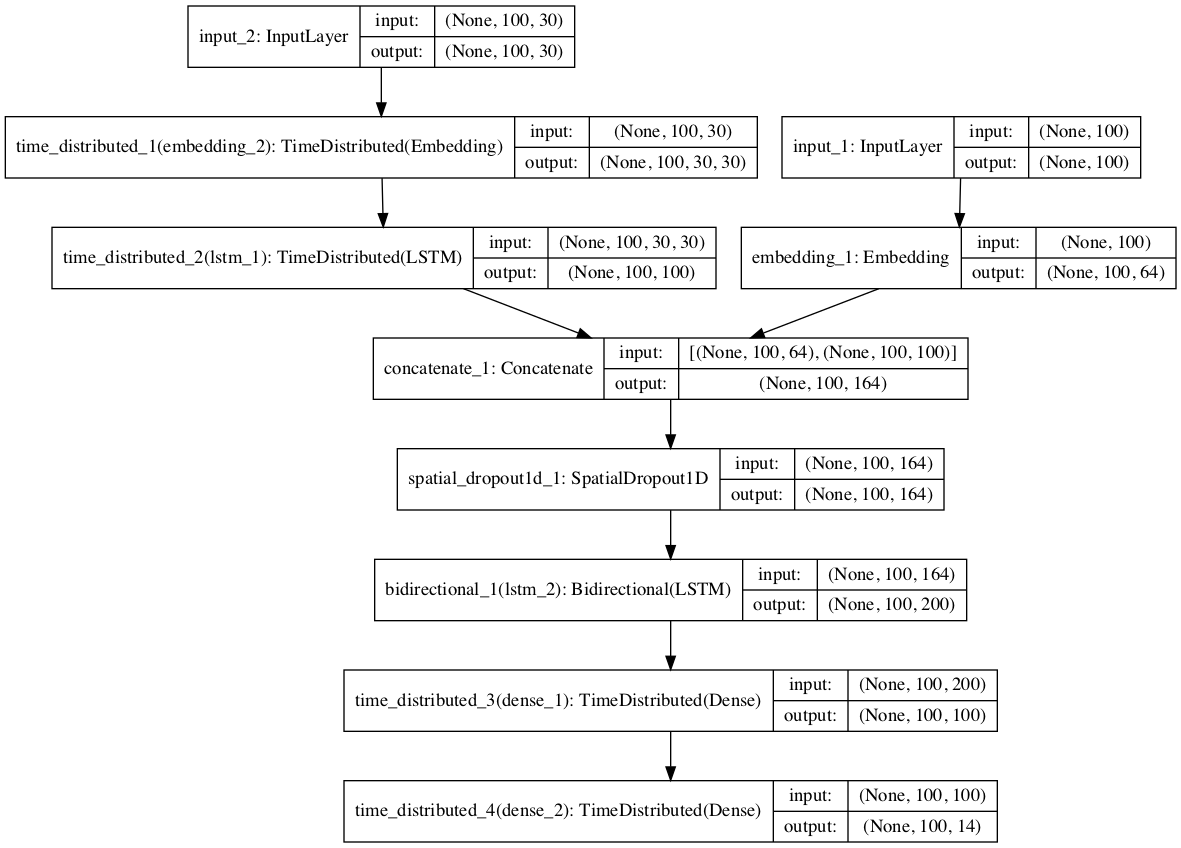

In [17]:
model.summary()
plot_model(model, to_file='model2_WL_CL_BiLSTM.png', show_shapes=True, show_layer_names=True)

In [18]:
#history = model.fit([X_word_tr,
#                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
#                    np.array(y_tr).reshape(len(y_tr), max_len, 1),
#                    batch_size=32, epochs=100, validation_split=0.1, verbose=1)
history = model.fit([X_word_tr,
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    np.array(y_tr).reshape(len(y_tr), max_len, 1),
                    batch_size=32, epochs=20, validation_split=0.2, verbose=2)

Train on 20360 samples, validate on 5090 samples
Epoch 1/20
 - 1276s - loss: 0.3000 - acc: 0.9318 - val_loss: 0.0835 - val_acc: 0.9739
Epoch 2/20
 - 1267s - loss: 0.0600 - acc: 0.9803 - val_loss: 0.0423 - val_acc: 0.9874
Epoch 3/20
 - 1192s - loss: 0.0341 - acc: 0.9888 - val_loss: 0.0311 - val_acc: 0.9907
Epoch 4/20
 - 991s - loss: 0.0246 - acc: 0.9919 - val_loss: 0.0260 - val_acc: 0.9927
Epoch 5/20
 - 966s - loss: 0.0192 - acc: 0.9937 - val_loss: 0.0235 - val_acc: 0.9937
Epoch 6/20
 - 969s - loss: 0.0159 - acc: 0.9948 - val_loss: 0.0226 - val_acc: 0.9940
Epoch 7/20
 - 970s - loss: 0.0136 - acc: 0.9955 - val_loss: 0.0199 - val_acc: 0.9949
Epoch 8/20
 - 963s - loss: 0.0115 - acc: 0.9962 - val_loss: 0.0210 - val_acc: 0.9948
Epoch 9/20
 - 966s - loss: 0.0100 - acc: 0.9968 - val_loss: 0.0206 - val_acc: 0.9950
Epoch 10/20
 - 961s - loss: 0.0082 - acc: 0.9973 - val_loss: 0.0208 - val_acc: 0.9951
Epoch 11/20
 - 956s - loss: 0.0076 - acc: 0.9975 - val_loss: 0.0231 - val_acc: 0.9947
Epoch 12/20

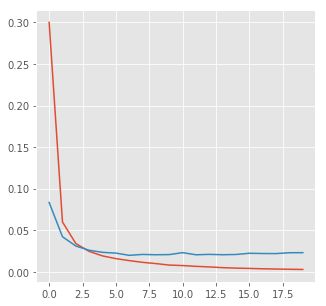

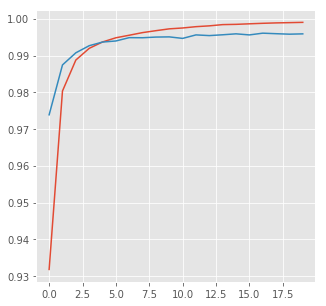

In [19]:
hist = pd.DataFrame(history.history)

import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(5,5))
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure(figsize=(5,5))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.show()

In [20]:
# Save the model
from keras.models import load_model

#model.save(r"C:/Users/20230326/wamex/data/2020_model_WL_CL_BiLSTM.h5")  # creates a HDF5 file 'my_model.h5'
model.save(r"../1-2 OzROCK/Files/autolabelled_MODEL_WL_CL_BiLSTM.h5")
#del model  # deletes the existing model

# TEST SET - auto-labelled using dictionary
## to see the model performance

In [21]:
y_pred = model.predict([X_word_te,
                        np.array(X_char_te).reshape((len(X_char_te), max_len, max_len_char))])
len(y_pred)

6363

In [22]:
def print_prediction(i):
    p = np.argmax(y_pred[i], axis=-1)
    print("{:15}|{:15}|{}".format("Word", "Truth", "Predicted"))
    print(40 * "=")

    for w, t, pred in zip(X_word_te[i], y_te[i], p):
        if w != 0:
            print("{:15} {:15} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))        

In [23]:
len(y_pred) # Number of sentences in prediction / test set

def get_results(i):
    words_value = []
    tags_true = []
    tags_pred = []
    p = np.argmax(y_pred[i], axis=-1)
    #print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
    #print(30 * "=")

    for w, t, pred in zip(X_word_te[i], y_te[i], p):
        if w != 0:
            #print("{:15}: {:5} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))
            words_value.append(idx2word[w])
            tags_true.append(idx2tag[t])
            tags_pred.append(idx2tag[pred])
            
    return words_value, tags_true, tags_pred

In [24]:
#for i in range(0, len(y_pred)):
words_tagged = []
labels_true = []
labels_predicted = []

for i in range(0, len(y_pred)):
    words_value, tags_true, tags_pred = get_results(i)
    words_tagged.extend(words_value)
    labels_true.extend(tags_true)
    labels_predicted.extend(tags_pred)

In [25]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

print(len(labels_true))
#print(y_te[0])

print(len(labels_predicted))
#print(y_pred[0])

#print(classification_report(labels_true, labels_predicted))
print(classification_report(labels_true, labels_predicted, digits=4))

174604
174604
             precision    recall  f1-score   support

   LOCATION     0.9666    0.9791    0.9728      3928
      STRAT     0.9016    0.9649    0.9322      1026
       ROCK     0.9724    0.9749    0.9737      5028
    MINERAL     0.9935    0.9908    0.9922      4351
ORE_DEPOSIT     0.9605    0.9620    0.9613       632
  TIMESCALE     0.9981    0.9944    0.9963       538

avg / total     0.9726    0.9799    0.9762     15503



In [26]:
print(labels_true[:10])
print(labels_predicted[:10])

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [27]:
# Predict all labels for the all auto-labelling dataset of 32,000 sentences
y_pred_all = model.predict([X_word,
                        np.array(X_char).reshape((len(X_char), max_len, max_len_char))])
len(y_pred_all)

31813

In [28]:
print(len(y_pred_all))
print(len(y))
print(len(X_word))

31813
31813
31813


In [29]:
# Save the prediction for the all auto-labelling dataset of 32,000 sentences
f = open(r"../1-2 OzROCK/Files/OzROCK dataset/BIG_set_byModel.txt", 'w')
f.write("Word DictionaryTag ModelTag\n")
for i in range(0, len(y_pred_all)):    
    p = np.argmax(y_pred_all[i], axis=-1)    
    #print(40 * "=")

    for w, pred, dic in zip(X_word[i], y[i], p):
        if w != 0:
            #print("{:15} {:15} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))  
            f.write(idx2word[w] + ' ' + idx2tag[pred] + ' ' + idx2tag[dic] + '\n')
        if idx2word[w] == '.':
            f.write('\n')
f.close()
print('BIG_set_byModel.txt file saved.')

BIG_set_byModel.txt file saved.


In [30]:
# Merge the all auto-labelling dataset of 32,000 sentences



# EVALUATION SET - Manually annotated by experts
## Manually annotated dataset for model evaluation

In [31]:
# Get the word ids for each sentence
test_X_word = [[word2idx[w[0]] for w in s] for s in test_sentences]

# Pad the sentences
test_X_word = pad_sequences(maxlen=max_len, sequences=test_X_word, value=word2idx["PAD"], padding='post', truncating='post')

test_X_char = []
for sentence in test_sentences:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    test_X_char.append(np.array(sent_seq))
    
# Map tags to a sequence numbers and the pad
test_y = [[tag2idx[w[1]] for w in s] for s in test_sentences]
print(y[0])

test_y = pad_sequences(maxlen=max_len, sequences=test_y, value=tag2idx["PAD"], padding='post', truncating='post')
#print(test_y[0])

print('Test set word shape = ', test_X_word.shape)
print('Test set character length = ', len(test_X_char))
print('Test set labels length = ', len(test_y))

[9 1 9 9 9 9 9 9 2 3 3 9 9 2 3 9 9 9 2 3 9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Test set word shape =  (2000, 100)
Test set character length =  2000
Test set labels length =  2000


In [32]:
# Predict the labels on the manually created TEST SET
test_y_pred = model.predict([test_X_word, np.array(test_X_char).reshape((len(test_X_char), max_len, max_len_char))])
len(test_y_pred) # Number of sentences in prediction / test set

2000

In [36]:
def get_test_results(i):
    words_value = []
    tags_true = []
    tags_pred = []
    p = np.argmax(test_y_pred[i], axis=-1)
    #print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
    #print(30 * "=")

    for w, t, pred in zip(test_X_word[i], test_y[i], p):
        if w != 0:
            #print("{:15}: {:5} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))
            words_value.append(idx2word[w])
            tags_true.append(idx2tag[t])
            tags_pred.append(idx2tag[pred])
            
    return words_value, tags_true, tags_pred

words_tagged = []
labels_true = []
labels_predicted = []

for i in range(0, len(test_y_pred)):
    words_value, tags_true, tags_pred = get_test_results(i)
    words_tagged.extend(words_value)
    labels_true.extend(tags_true)
    labels_predicted.extend(tags_pred)
    
print(len(labels_true))
#print(y_te[2000])

print(len(labels_predicted))
#print(y_pred[2000])

#print(classification_report(labels_true, labels_predicted))
print(classification_report(labels_true, labels_predicted, digits=4))

51275
51275
             precision    recall  f1-score   support

   LOCATION     0.5833    0.6784    0.6273       970
       ROCK     0.7488    0.7723    0.7604      1853
      STRAT     0.7517    0.6889    0.7189       646
    MINERAL     0.7669    0.9038    0.8297      1278
  TIMESCALE     0.9417    0.9327    0.9372       208
ORE_DEPOSIT     0.8169    0.7859    0.8011       369

avg / total     0.7356    0.7838    0.7575      5324



In [34]:
f = open(filename_result, 'w')
f.write("Word GroundTruth Predicted\n")
for i in range(0, len(test_y_pred)):    
    p = np.argmax(test_y_pred[i], axis=-1)    
    #print(40 * "=")

    for w, t, pred in zip(test_X_word[i], test_y[i], p):
        if w != 0:
            #print("{:15} {:15} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))  
            f.write(idx2word[w] + ' ' + idx2tag[t] + ' ' + idx2tag[pred] + '\n')
        if idx2word[w] == '.':
            f.write('\n')
f.close()
#for i in range(0, 10):
    #test_prediction(i)
print('File saved.')

File saved.
